<a href="https://colab.research.google.com/github/Manuel0104/Enhancement-ultrasonic-tomographic-image/blob/main/segmentation_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **CPU-GPU CHARACTERISTICS** 

In [ ]:
from psutil import *

In [ ]:
cpu_count()

2

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [ ]:
!df -h / awk '{print $4}'

df: awk: No such file or directory
df: '{print $4}': No such file or directory
Filesystem      Size  Used Avail Use% Mounted on
overlay          79G   38G   41G  48% /


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-8a19e933-fcde-8ab3-07b9-cdb5d94a3ec6)


In [ ]:
!nvidia-smi 

Tue Sep  6 12:29:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## PACKAGES INSTALLATION

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install segmentation-models
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip uninstall h5py
!pip install h5py==2.10.0
#Force session restart
exit(0)

In [ ]:
%matplotlib inline

In [ ]:
import glob
from tifffile import imread
import cv2
import os
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import random
import socket
from tqdm import tqdm

In [ ]:
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.utils import set_trainable

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


## LOADING DATA

In [ ]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128 

#Capture training image info as a list
image_names = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TRAIN_IMAGES/TIFF/*.tiff")
train_images = []
image_names.sort()
#image_names_subset = image_names[0:num_images]
for image in image_names:
    images = cv2.imread(image, cv2.IMREAD_COLOR) 
    img = cv2.resize(images, (SIZE_Y, SIZE_X)) 
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    train_images.append(img)
#Convert list to array for machine learning processing  
train_images = np.array(train_images)
    

#Capture mask/label info as a list
mask_names = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TRAIN_MASKS/Qupath_mask/*.tif")
train_masks = [] 
mask_names.sort()
#mask_names_subset = mask_names[0:num_images]
for mask in mask_names:
    masks = cv2.imread(mask, 0)
    mask = cv2.resize(masks, (SIZE_Y, SIZE_X))/255 #/193 
    train_masks.append(mask)
#Convert list to array for machine learning processing          
train_masks = np.array(train_masks)

In [ ]:
train_images.shape,train_masks.shape

((32, 128, 128, 3), (32, 128, 128))

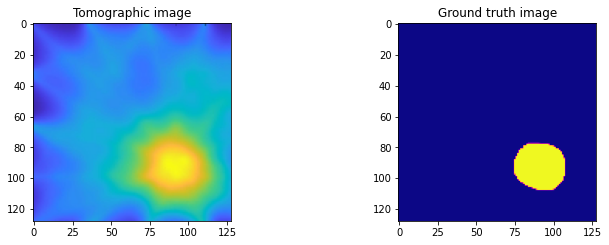

In [ ]:
img_number = random.randint(0, len(train_images)-1)
img = train_images[21]
mask = train_masks[21]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Tomographic image')
plt.imshow(img)
plt.subplot(222)
plt.title('Ground truth image')
plt.imshow(mask,cmap='plasma')
plt.show()

In [ ]:
#Use customary x_train and y_train variables
X = train_images
Y = train_masks
Y = np.expand_dims(Y, axis=3) #May not be necessary.. leftover from previous code 

from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.25, random_state=0)

# preprocess input
#x_train = preprocess_input(x_train)
#x_val = preprocess_input(x_val)

In [ ]:
x_train.max(),x_val.max(),y_train.max(),y_val.max(),x_train.shape,y_train.shape,x_val.shape,y_val.shape

(255,
 255,
 1.0,
 1.0,
 (24, 128, 128, 3),
 (24, 128, 128, 1),
 (8, 128, 128, 3),
 (8, 128, 128, 1))

In [ ]:
#scaler = MinMaxScaler()
#x_train=scaler.fit_transform(x_train.reshape(-1, x_train.shape[-1])).reshape(x_train.shape)
#x_val=scaler.fit_transform(x_val.reshape(-1, x_val.shape[-1])).reshape(x_val.shape)
#y_train=scaler.fit_transform(y_train.reshape(-1, y_train.shape[-1])).reshape(y_train.shape)
#y_val=scaler.fit_transform(y_val.reshape(-1, y_val.shape[-1])).reshape(y_val.shape)

In [ ]:
#y_train = np.squeeze(y_train,axis=3)
#y_val = np.squeeze(y_val,axis=3)
#print(y_train.shape,y_val.shape)

In [ ]:
n = random.choice(np.arange(0,22))
print(n)
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.imshow(x_train[n])
plt.title('IMAGE')
plt.subplot(222)
#plt.imshow(y_train[n])
plt.imshow(np.squeeze(y_train,axis=3)[n])
plt.title('MASK')

## TRAIN MODEL 

In [ ]:
BACKBONE = 'efficientnetb4'
BACKBONE2 = 'densenet201'
BACKBONE3 = 'resnet50'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# define model
model = sm.Unet(BACKBONE3,encoder_weights='imagenet')
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)])
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mse'])

print(model.summary())

In [ ]:
# set all layers trainable and recompile model
history = model.fit(x=x_train,y=y_train,epochs=400,validation_data=(x_val, y_val))
accuracy = model.evaluate(x_val, y_val)

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']
iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']
f1_score = history.history['f1-score']
val_f1_score = history.history['val_f1-score']
epochs = range(1, len(loss) + 1)
plt.figure(figsize=(16,16))
plt.subplot(311)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(312)
plt.plot(epochs, iou_score, 'y', label='Training iou_score')
plt.plot(epochs, val_iou_score, 'r', label='Validation iou_score')
plt.title('Training and validation iou_score')
plt.xlabel('Epochs')
plt.ylabel('iou_score')
plt.ylim(0, 1)
plt.legend()
plt.subplot(313)
plt.plot(epochs, f1_score, 'y', label='Training f1-score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1-score')
plt.title('Training and validation f1-score')
plt.xlabel('Epochs')
plt.ylabel('f1-score')
plt.legend()
plt.ylim(0, 1)
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_efficientnetb7_400_epochs_expdata.h5')

## MODEL TESTING


In [ ]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
from tensorflow import keras
model = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Unet_efficientnetb7_400_epochs_expdata.h5', compile=False)
model2 = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_densenet201_400_epochs_expdata.h5', compile=False)
model3 = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_resnet50_400_epochs_expdata.h5', compile=False)

In [ ]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
image_names_test = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TEST_IMAGES/*.tiff")
test_images = []
image_names_test.sort()
#image_names_subset = image_names[0:num_images]
for image in image_names_test:
    images_2 = cv2.imread(image, cv2.IMREAD_COLOR) 
    img_2 = cv2.resize(images_2, (SIZE_Y, SIZE_X)) 
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2BGR)
    test_images.append(img_2)
#Convert list to array for machine learning processing  
test_images = np.array(test_images)
    

#Capture mask/label info as a list
mask_names_test = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TEST_MASKS/*.tif")
test_masks = [] 
mask_names_test.sort()
#mask_names_subset = mask_names[0:num_images]
for mask in mask_names_test:
    masks_2 = cv2.imread(mask, 0)
    mask_2 = cv2.resize(masks_2, (SIZE_Y, SIZE_X))/255 #/193 
    test_masks.append(mask_2)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)

In [ ]:
test_images.shape,test_masks.shape

((8, 128, 128, 3), (8, 128, 128))

In [ ]:
img_number = random.randint(0, len(test_images)-1)
img = test_images[img_number]
mask = test_masks[img_number]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Mask')
plt.imshow(mask,cmap='plasma')
plt.show()

In [ ]:
def plot_img_label(img,mask, lbl, lbl2,lbl3, img_title="Tomographic image",mask_title = "Ground-truth", lbl_title="label",lbl_title_2="label",lbl_title_3="label",**kwargs):
    fig, (ai,am,al,al2,al3) = plt.subplots(1,5, figsize=(12,6), gridspec_kw=dict(width_ratios=(1,1,1,1,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    #fig.colorbar(im, ax=ai)
    ma = am.imshow(mask,cmap='plasma', clim=(0,1))
    am.set_title(mask_title)
    al.imshow(lbl, cmap='plasma')
    al.set_title(lbl_title)
    plt.tight_layout()
    al2.imshow(lbl2, cmap='plasma')
    al2.set_title(lbl_title_2)
    plt.tight_layout()
    al3.imshow(lbl3, cmap='plasma')
    al3.set_title(lbl_title_3)
    plt.tight_layout()

In [ ]:
for i in range(len(test_images)):    
    test_img = test_images[i]
    mask_img = test_masks[i]
    assert img_2.ndim in (2,3)
    test_img = test_img if (test_img.ndim==2 or test_img.shape[-1]==3) else test_img[...,0]
    test_img = cv2.resize(test_img, (SIZE_Y, SIZE_X))
    #test_img = cv2.cvtColor(test_img, cv2.COLOR_RGB2BGR)
    test_img = np.expand_dims(test_img, axis=0)
    mask_img = cv2.resize(mask_img, (SIZE_Y, SIZE_X))
    prediction = model.predict(test_img)
    prediction_image = prediction.reshape(mask_2.shape)
    prediction_2 = model2.predict(test_img)
    prediction_image_2 = prediction_2.reshape(mask_2.shape)
    prediction_3 = model3.predict(test_img)
    prediction_image_3 = prediction_3.reshape(mask_2.shape)
    test_img = np.squeeze(test_img,axis=0)
    #mask_img = np.squeeze(mask_img,axis=2)
    plot_img_label(test_img,mask_img,prediction_image,prediction_image_2,prediction_image_3, lbl_title="Unet_EfficientNetB7",lbl_title_2="Unet_DenseNet-201",lbl_title_3="Unet_ResNet-50")

In [ ]:
test_img_2 = test_images[7]
mask_img_2 = test_masks[7]
test_img_2 = np.expand_dims(test_img_2, axis=0)
prediction_2 = model.predict(test_img_2)
prediction_image_2 = prediction_2.reshape(mask_2.shape)
#prediction_image_2 =np.squeeze(prediction_2,axis=0)
#prediction_image_2 = np.squeeze(prediction_image_2,axis=2)
prediction_image_2.shape,prediction_image_2.dtype,prediction_image_2.min(),prediction_image_2.max()

((128, 128), dtype('float32'), 1.079683e-06, 0.99999833)

In [ ]:
plt.figure(1)
plt.imshow(prediction_image_2,cmap='rainbow')
plt.figure(2)
plt.imshow(prediction_image_2,cmap='plasma')
plt.figure(3)
plt.imshow(prediction_image_2,cmap='inferno')
plt.figure(4)
plt.imshow(prediction_image_2,cmap='magma')
plt.figure(5)
plt.imshow(prediction_image_2,cmap='cividis')

## METRICS 

In [ ]:
from keras.metrics import MeanIoU
from random import randint
from sklearn import metrics

In [ ]:
n = randint(0,7)
test_img_2 = test_images[5]
mask_img_2 = test_masks[5]
y_test = mask_img_2.reshape(mask_2.shape)
test_img_2 = np.expand_dims(test_img_2, axis=0)
prediction_2 = model.predict(test_img_2)
prediction_image_2 = prediction_2.reshape(mask_2.shape)
prediction_3 = model2.predict(test_img_2)
prediction_image_3 = prediction_3.reshape(mask_2.shape)
prediction_4 = model3.predict(test_img_2)
prediction_image_4 = prediction_4.reshape(mask_2.shape)
print(n)

4


In [ ]:
### IoU SCORE###
y_pred_thresholded1 = prediction_image_2 > 0.5 
y_pred_thresholded2 = prediction_image_3 > 0.5 
y_pred_thresholded3 = prediction_image_4 > 0.5 

#MODEL 1 
intersection1 = np.logical_and(y_test, y_pred_thresholded1)
union1 = np.logical_or(y_test, y_pred_thresholded1)
iou_score1 = np.sum(intersection1) / np.sum(union1)
print("Mean IoU(Unet_efficientnetb4) = ", str(iou_score1*100)+'%')
#MODEL 2 
intersection2 = np.logical_and(y_test, y_pred_thresholded2)
union2 = np.logical_or(y_test, y_pred_thresholded2)
iou_score2 = np.sum(intersection2) / np.sum(union2)
print("Mean IoU(Unet_DenseNet201) = ", str(iou_score2*100)+'%')
#MODEL 3
intersection3 = np.logical_and(y_test, y_pred_thresholded3)
union3 = np.logical_or(y_test, y_pred_thresholded3)
iou_score3 = np.sum(intersection3) / np.sum(union3)
print("Mean IoU(Unet_Resnet50) = ", str(iou_score3*100)+'%')
plot_img_label(test_img,y_test,prediction_image_2,prediction_image_3,prediction_image_4, lbl_title="Unet_efficientnetb4",lbl_title_2="Unet_DenseNet201",lbl_title_3="Unet_resnet50")

In [ ]:
#num_classes = 2
#IOU_keras_Unet_efficientnetb6 = MeanIoU(num_classes=num_classes)
#IOU_keras_Unet_efficientnetb7 = MeanIoU(num_classes=num_classes)
#IOU_keras_Unet_resnet50 = MeanIoU(num_classes=num_classes)
#IOU_keras_Unet_efficientnetb6.update_state(mask_img_2.reshape(-1), prediction_image_2.reshape(-1))
#IOU_keras_Unet_efficientnetb7.update_state(mask_img_2.reshape(-1), prediction_image_3.reshape(-1))
#IOU_keras_Unet_resnet50.update_state(mask_img_2.reshape(-1), prediction_image_4.reshape(-1))
#test_img = np.squeeze(test_img_2,axis=0)
#plot_img_label(test_img,mask_img_2,prediction_image_2,prediction_image_3,prediction_image_4, lbl_title="Unet_efficientnetb6",lbl_title_2="Unet_efficientnetb7",lbl_title_3="Unet_resnet50")
#print("Mean IoU(Unet_efficientnetb6) =", str(IOU_keras_Unet_efficientnetb6.result().numpy()*100) +'%')
#print("Mean IoU(Unet_efficientnetb7) =", str(IOU_keras_Unet_efficientnetb7.result().numpy()*100) +'%')
#print("Mean IoU(Unet_resnet50) =", str(IOU_keras_Unet_resnet50.result().numpy()*100) +'%')

## METRICS IMPROVEMENT (ENSEMBLE)


In [ ]:
from keras.metrics import MeanIoU
import pandas as pd

In [ ]:
import efficientnet.tfkeras
from tensorflow.keras.models import load_model
from tensorflow import keras
model = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_efficientnetb4_400_epochs_expdata.h5', compile=False)
model2 = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_densenet201_400_epochs_expdata.h5', compile=False)
model3 = load_model('/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/MODELS/Qupathmask_Unet_resnet50_400_epochs_expdata.h5', compile=False)

In [ ]:
#Resizing images is optional, CNNs are ok with large images
SIZE_X = 128 #Resize images (height  = X, width = Y)
SIZE_Y = 128

#Capture training image info as a list
image_names_test = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TEST_IMAGES/*.tiff")
test_images = []
image_names_test.sort()
#image_names_subset = image_names[0:num_images]
for image in image_names_test:
    images_2 = cv2.imread(image, cv2.IMREAD_COLOR) 
    img_2 = cv2.resize(images_2, (SIZE_Y, SIZE_X)) 
    img_2 = cv2.cvtColor(img_2, cv2.COLOR_RGB2BGR)
    test_images.append(img_2)
#Convert list to array for machine learning processing  
test_images = np.array(test_images)
    

#Capture mask/label info as a list
mask_names_test = glob.glob("/content/drive/MyDrive/Colab_Notebooks/LABproject/U-Net/DATA/TEST_MASKS/*.tif")
test_masks = [] 
mask_names_test.sort()
#mask_names_subset = mask_names[0:num_images]
for mask in mask_names_test:
    masks_2 = cv2.imread(mask, 0)
    mask_2 = cv2.resize(masks_2, (SIZE_Y, SIZE_X))/255 #/193 
    test_masks.append(mask_2)
#Convert list to array for machine learning processing          
test_masks = np.array(test_masks)

In [ ]:
models = [model,model2,model3]

In [ ]:
#i = random.randint(0, len(test_images)-1)
i = 7
print(i)

7


In [ ]:
img = test_images[i]
mask = test_masks[i]
plt.figure(figsize=(12, 8))
plt.subplot(221)
plt.title('Tomographic image')
plt.imshow(img)
plt.subplot(222)
plt.title('Ground truth image')
plt.imshow(mask,cmap='plasma')
plt.show()
print(img_number)

In [ ]:
test_img_2 = test_images[i]
mask_img_2 = test_masks[i]
test_img_2 = np.expand_dims(test_img_2, axis=0)
y_test = mask_img_2.reshape(mask_2.shape)
prediction_1 = model.predict(test_img_2)
prediction_image_1 = prediction_1.reshape(mask_2.shape)
prediction_2 = model2.predict(test_img_2)
prediction_image_2 = prediction_2.reshape(mask_2.shape)
prediction_3 = model3.predict(test_img_2)
prediction_image_3 = prediction_3.reshape(mask_2.shape)
print(mask_img_2.shape,prediction_image_1.min(),prediction_image_1.max())

(128, 128) 1.7739742e-09 1.0


In [ ]:
preds=np.array([prediction_1, prediction_2, prediction_3])
#Set weights to assign the weight of each model 
weights = [0.3, 0.5, 0.2] 
print(preds.shape)

(3, 1, 128, 128, 1)


In [ ]:
weighted_preds = np.tensordot(preds, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.amax(weighted_preds, axis=3)
weighted_ensemble_prediction = weighted_ensemble_prediction.reshape(mask_2.shape)
weighted_ensemble_prediction.shape

(128, 128)

In [ ]:
y_pred1_argmax=np.amax(prediction_1, axis=3)
y_pred1_argmax = y_pred1_argmax.reshape(mask_2.shape)
y_pred2_argmax=np.amax(prediction_2, axis=3)
y_pred2_argmax = y_pred2_argmax.reshape(mask_2.shape)
y_pred3_argmax=np.amax(prediction_3, axis=3)
y_pred3_argmax = y_pred3_argmax.reshape(mask_2.shape)

In [ ]:
df = pd.DataFrame([])

for w1 in range(0,10):
    for w2 in range(0,10):
        for w3 in range(0,10):
            wts = [w1/10.,w2/10.,w3/10.]
            wted_preds = np.tensordot(preds, wts, axes=((0),(0)))
            wted_ensemble_pred = np.amax(wted_preds, axis=3)
            wted_ensemble_pred = wted_ensemble_pred.reshape(mask_2.shape)

            y_pred_thresholded_wted = wted_ensemble_pred > 0.5

            intersectionwted_pred = np.logical_and(y_test, y_pred_thresholded_wted)
            unionwted_pred = np.logical_or(y_test, y_pred_thresholded_wted)
            iou_wted = np.sum(intersectionwted_pred) / np.sum(unionwted_pred)
            
            #print("Now predciting for weights :", w1/10., w2/10., w3/10., " : IOU = ", str(iou_wted*100)+'%')
            df = df.append(pd.DataFrame({'wt1':wts[0],'wt2':wts[1], 
                                         'wt3':wts[2], 'IOU': iou_wted}, index=[0]), ignore_index=True)
            
max_iou_row = df.iloc[df['IOU'].idxmax()]
print("Max IOU of ", str(max_iou_row[3]*100)+'%', " obained with w1=", max_iou_row[0],
      " w2=", max_iou_row[1], " and w3=", max_iou_row[2])         


#############################################################
opt_weights = [max_iou_row[0], max_iou_row[1], max_iou_row[2]]

#Use tensordot to sum the products of all elements over specified axes.
opt_weighted_preds = np.tensordot(preds, opt_weights, axes=((0),(0)))
opt_weighted_ensemble_prediction = np.amax(opt_weighted_preds, axis=3)
opt_weighted_ensemble_prediction = opt_weighted_ensemble_prediction.reshape(mask_2.shape)

Max IOU of  98.91205802357209%  obained with w1= 0.6  w2= 0.4  and w3= 0.9


In [ ]:
def plot_img_label_2(img,mask, lbl, lbl2,lbl3,lbl4,lbl5, img_title="image",mask_title = "ground-truth", lbl_title="label",lbl_title_2="label",lbl_title_3="label",lbl_title_4="label",lbl_title_5="label",**kwargs):
    fig, (ai,am,al,al2,al3,al4,al5) = plt.subplots(1,7, figsize=(20,20), gridspec_kw=dict(width_ratios=(1,1,1,1,1,1,1)))
    im = ai.imshow(img, cmap='gray', clim=(0,1))
    ai.set_title(img_title)    
    #fig.colorbar(im, ax=ai)
    ma = am.imshow(mask,cmap='plasma', clim=(0,1))
    am.set_title(mask_title)
    al.imshow(lbl, cmap='plasma')
    al.set_title(lbl_title)
    plt.tight_layout()
    al2.imshow(lbl2, cmap='plasma')
    al2.set_title(lbl_title_2)
    plt.tight_layout()
    al3.imshow(lbl3, cmap='plasma')
    al3.set_title(lbl_title_3)
    plt.tight_layout()
    al4.imshow(lbl4, cmap='plasma')
    al4.set_title(lbl_title_4)
    plt.tight_layout()
    al5.imshow(lbl5, cmap='plasma')
    al5.set_title(lbl_title_5)
    plt.tight_layout()

In [ ]:
test_image_2 = test_images[i]
mask_image_2 = test_masks[i]
test_image_2 = np.expand_dims(test_image_2, axis=0)
pred_1 = model.predict(test_img_2)
pred_image_1 = prediction_1.reshape(mask_2.shape)
pred_2 = model2.predict(test_img_2)
pred_image_2 = prediction_2.reshape(mask_2.shape)
pred_3 = model3.predict(test_img_2)
pred_image_3 = prediction_3.reshape(mask_2.shape)

test_preds = np.array([pred_1, pred_2, pred_3])

weighted_test_preds = np.tensordot(test_preds, opt_weights, axes=((0),(0)))
weighted_ensemble_test_prediction = np.amax(weighted_test_preds, axis=3)
weighted_ensemble_test_prediction = weighted_ensemble_test_prediction.reshape(mask_2.shape)
print(i)

7


In [ ]:
#test_img = np.squeeze(test_img_2,axis=0)
### IoU SCORE###
y_pred_thresholded1 = pred_image_1 > 0.5 
y_pred_thresholded2 = pred_image_2 > 0.5 
y_pred_thresholded3 = pred_image_3 > 0.5
y_pred_thresholdedweighted = weighted_ensemble_prediction > 0.5
y_pred_thresholdedweighted_max = opt_weighted_ensemble_prediction > 0.5

#MODEL 1 
intersection1 = np.logical_and(mask_image_2, y_pred_thresholded1)
union1 = np.logical_or(y_test, y_pred_thresholded1)
iou_score1 = np.sum(intersection1) / np.sum(union1)
print("Mean IoU(Unet_efficientnetb4) = ", str(iou_score1*100)+'%')
#MODEL 2 
intersection2 = np.logical_and(mask_image_2, y_pred_thresholded2)
union2 = np.logical_or(y_test, y_pred_thresholded2)
iou_score2 = np.sum(intersection2) / np.sum(union2)
print("Mean IoU(Unet_DenseNet201) = ", str(iou_score2*100)+'%')
#MODEL 3
intersection3 = np.logical_and(mask_image_2, y_pred_thresholded3)
union3 = np.logical_or(y_test, y_pred_thresholded3)
iou_score3 = np.sum(intersection3) / np.sum(union3)
print("Mean IoU(Unet_Resnet50) = ", str(iou_score3*100)+'%')
#ENSEMBLE MODEL 
intersection4 = np.logical_and(mask_image_2, y_pred_thresholdedweighted)
union4 = np.logical_or(y_test, y_pred_thresholdedweighted)
iou_score4 = np.sum(intersection4) / np.sum(union4)
print("Mean IoU(Unet_ENSEMBLE_MODEL) = ", str(iou_score4*100)+'%')
#OPTIMAL ENSEMBLE MODEL 
intersection5 = np.logical_and(mask_image_2, y_pred_thresholdedweighted_max)
union5 = np.logical_or(y_test, y_pred_thresholdedweighted_max)
iou_score5 = np.sum(intersection5) / np.sum(union5)
print("Mean IoU(Unet_ENSEMBLE_MODEL) = ", str(iou_score5*100)+'%')

######PLOT THE RESUTLS#########
test_image_2 = np.squeeze(test_image_2,axis=0)
plot_img_label_2(test_image_2,mask_image_2,prediction_image_1,prediction_image_2,prediction_image_3,weighted_ensemble_prediction,weighted_ensemble_test_prediction, lbl_title="Unet_efficientnetb4",lbl_title_2="Unet_DenseNet201",lbl_title_3="Unet_resnet50",lbl_title_4 = "ensembled_model",lbl_title_5="opt_ensembled_model")

## IMAGES FUSION

In [ ]:
import cv2
import numpy as np 

In [ ]:
IMG_0 = X[0]
IMG_1 = X[1]
IMG_2 = X[2]
IMG_3 = X[3]
IMG_4 = X[4]
IMG_5 = X[5]
IMG_6 = X[6]
IMG_7 = X[7]
IMG_8 = X[8]
IMG_9 = X[9]
IMG_10 = X[10]
IMG_11= X[11]
IMG_12 = X[12]

In [ ]:
IMG = np.correlate(X,axis=0,dtype=np.int64)
#print(IMG.shape)
#print(IMG.dtype)
#print(IMG)

TypeError: ignored

In [ ]:
#IMG = cv2.addWeighted(IMG_1,0.5,IMG_2,0.5,0)
#IMG1 = cv2.add(IMG_1,IMG_2,IMG_3)

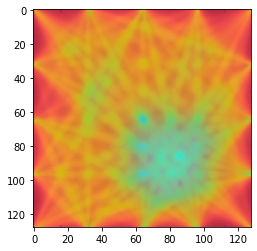

In [ ]:
plt.imshow(IMG)

In [ ]:
IMG = np.expand_dims(IMG, axis=0)
PREDICTION = model.predict(IMG)
PREDICTION_IMAGE = PREDICTION.reshape(mask.shape)
PREDICTION2 = model2.predict(IMG)
PREDICTION_IMAGE2 = PREDICTION2.reshape(mask.shape)
PREDICTION3 = model3.predict(IMG)
PREDICTION_IMAGE3 = PREDICTION3.reshape(mask.shape)

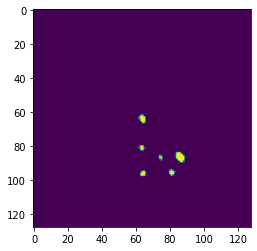

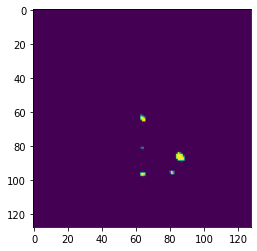

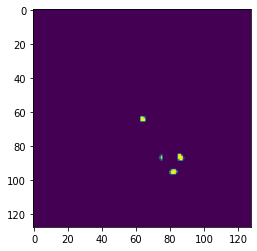

In [ ]:
plt.figure(1)
plt.imshow(PREDICTION_IMAGE)
plt.figure(2)
plt.imshow(PREDICTION_IMAGE2)
plt.figure(3)
plt.imshow(PREDICTION_IMAGE3)